In [18]:
# importation des packages
import numpy as np
import pandas as pd
import seaborn as sns

# importation des modules
import scipy.stats as sps
import mysql.connector as sql

import matplotlib.pyplot as plt

import matplotlib.dates as mdates
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from pyproj import Proj, transform

# magic
import warnings
warnings.filterwarnings('ignore')

db_connection = sql.connect(host='mysql.ozna.me', user='pnr1', password='groupesaepnr1', database='PNR', port='3306')

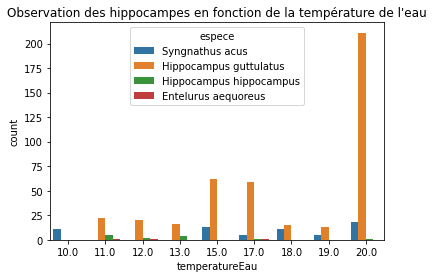

In [19]:
# 1 - Observation des hippocampes en fonction de la température de l'eau

attributs = "temperatureEau, espece"
df = pd.read_sql(f"SELECT {attributs} FROM Obs_Hippocampe JOIN Observation ON obsH = idObs", con=db_connection)

sns.countplot(x='temperatureEau', hue='espece', data=df)
plt.title("Observation des hippocampes en fonction de la température de l'eau")
print()


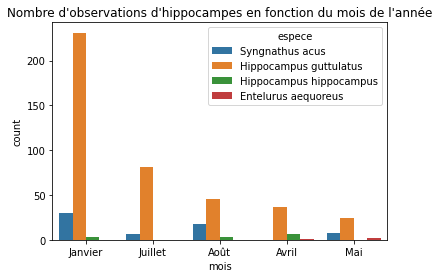

In [20]:
# 2 - Observation des hippocampes en fonction du mois de l'année

attributs = "MONTH(dateObs) mois, espece"
restriction = "temperatureEau IS NOT NULL"
df = pd.read_sql(f"SELECT {attributs} FROM Obs_Hippocampe JOIN Observation ON obsH = idObs WHERE {restriction}",
                 con=db_connection)

filter = {
    1: "Janvier",
    2: "Février",
    3: "Mars",
    4: "Avril",
    5: "Mai",
    6: "Juin",
    7: "Juillet",
    8: "Août",
    9: "Septembre",
    10: "Octobre",
    11: "Novembre",
    12: "Décembre"
}

sns.countplot(x='mois', hue='espece', data=df.replace(filter))
plt.title("Nombre d'observations d'hippocampes en fonction du mois de l'année")
print()


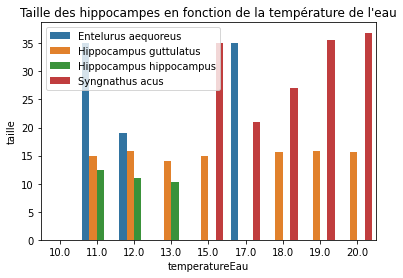

In [21]:
df = pd.read_sql("SELECT espece, temperatureEau, taille FROM Obs_Hippocampe", con=db_connection)
new_df = df.groupby(["espece", "temperatureEau"])[["taille"]].mean().reset_index()

sns.barplot(x='temperatureEau', y='taille', hue='espece', data=new_df)
plt.legend(loc='upper left')
plt.title("Taille des hippocampes en fonction de la température de l'eau")
print()

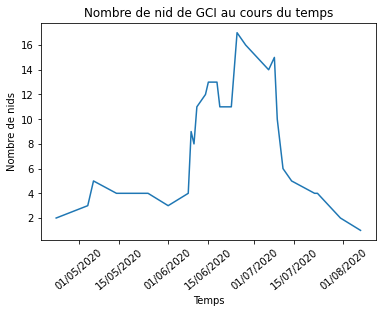

In [22]:
df = pd.read_sql("SELECT leNid, MIN(dateObs), MAX(dateObs), DATEDIFF(MAX(dateObs), MIN(dateObs)) FROM Obs_GCI JOIN Observation ON idObs = obsG GROUP BY leNid;", con=db_connection)
dates = pd.read_sql("SELECT DISTINCT dateObs FROM Obs_GCI JOIN Observation ON idObs = obsG ORDER BY dateObs;", con=db_connection)

data = pd.DataFrame(index = dates['dateObs'], columns = df['leNid'])

for i in range(data.columns.size):
    for j in range(data.index.size):
        if (data.index[j] >= df['MIN(dateObs)'][i] and data.index[j] <= df['MAX(dateObs)'][i]):
            data.at[data.index[j], data.columns[i]] = 1
        else:
            data.at[data.index[j], data.columns[i]] = 0

total = []
for i in range(data.index.size):
    total.append(sum(data.iloc[i]))

plt.plot((dates['dateObs']), total)
plt.xticks(rotation=40)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%Y"))
plt.title("Nombre de nid de GCI au cours du temps")
plt.xlabel("Temps")
plt.ylabel("Nombre de nids")
plt.show()

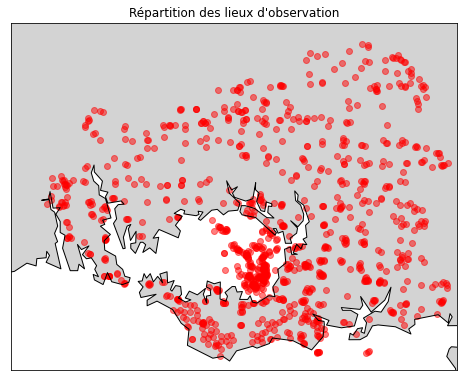

In [23]:
places = pd.read_sql("SELECT coord_Lambert_X, coord_Lambert_Y FROM Lieu", con=db_connection)
inProj = Proj(init='epsg:2154')
outProj = Proj(init='epsg:4326')

# Extract the data we're interested in
lat = places['coord_Lambert_X'].values
lon = places['coord_Lambert_Y'].values
places.dropna(inplace=True)

# Convert Lambert93 coordinates to GPS
for i in range(len(lat)):
    lon[i], lat[i] = transform(inProj, outProj, lat[i], lon[i])

# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h',
            lat_0=47.6335, lon_0=-2.7885,
            height=35E3, width=45E3)

m.drawcoastlines(color='black')
m.drawcountries(color='lightgray')
m.fillcontinents(color='lightgray')

# 2. Draw the points
m.scatter(lon, lat, latlon=True, c='red',
          cmap='Reds', alpha=0.5)

plt.title("Répartition des lieux d'observation")
plt.show()

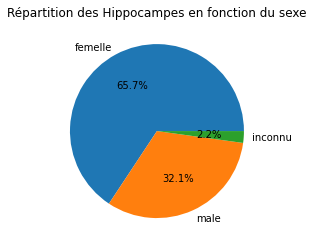

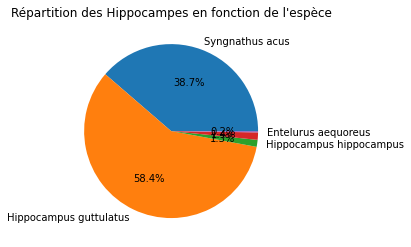

In [24]:
df = pd.read_sql("SELECT sexe, COUNT(*) nbIndividus FROM Obs_Hippocampe GROUP BY sexe", con=db_connection)
plt.pie(df['nbIndividus'], labels=df['sexe'], autopct='%1.1f%%')
plt.title("Répartition des Hippocampes en fonction du sexe")
plt.show()

df = pd.read_sql("SELECT espece, COUNT(*) nbIndividus FROM Obs_Hippocampe GROUP BY espece", con=db_connection)
plt.pie(df['nbIndividus'], labels=df['espece'], autopct='%1.1f%%')
plt.title("Répartition des Hippocampes en fonction de l'espèce")
plt.show()

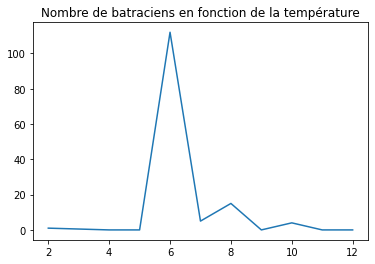

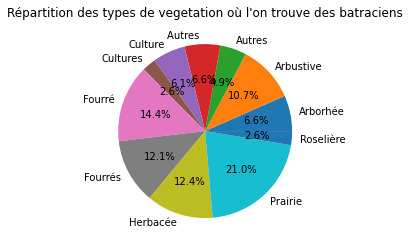

In [25]:
df = pd.read_sql("""SELECT temperature, SUM(nombreAdultes)
                    FROM Obs_Batracien
                    WHERE temperature IS NOT NULL
                    GROUP BY temperature
                    ORDER BY temperature;"""
                 , con=db_connection)
plt.plot(df['temperature'], df['SUM(nombreAdultes)'])
plt.title("Nombre de batraciens en fonction de la température")
plt.show()

df = pd.read_sql("SELECT * FROM Vegetation", con=db_connection)
df.dropna(inplace=True)
tmp = pd.DataFrame()
for s in df.values:
    for w in s[2].split(','):
        tmp = tmp.append({'vegetation': w, 'index': s[0]}, ignore_index=True)
tmp.groupby(['vegetation']).count()
plt.pie(tmp.groupby(['vegetation']).count()['index'], labels=tmp.groupby(['vegetation']).count()['index'].index, autopct='%1.1f%%')
plt.title("Répartition des types de vegetation où l'on trouve des batraciens")
plt.show()

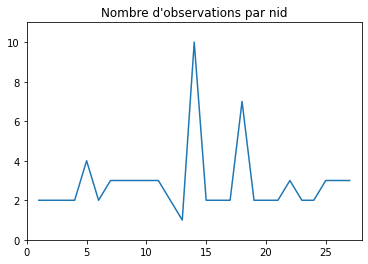

In [26]:
df = pd.read_sql("""SELECT idNid, COUNT(*) AS nbObs
                    FROM Nid_GCI
                    JOIN Obs_GCI OG on Nid_GCI.idNid = OG.leNid
                    GROUP BY idNid;"""
                 , con=db_connection)
plt.plot(df['idNid'], df['nbObs'])
plt.axis([0, df['idNid'].max() +1, 0, df['nbObs'].max() +1])
plt.title("Nombre d'observations par nid")
plt.show()

In [27]:
# TABLES
print(pd.read_sql("""SHOW TABLES
                    ;"""
                 , con=db_connection))


      Tables_in_PNR
0          AObserve
1          Chouette
2              Lieu
3   Lieu_Vegetation
4           Nid_GCI
5     Obs_Batracien
6      Obs_Chouette
7           Obs_GCI
8    Obs_Hippocampe
9        Obs_Loutre
10      Observateur
11      Observation
12       Vegetation
13       ZoneHumide
14             user


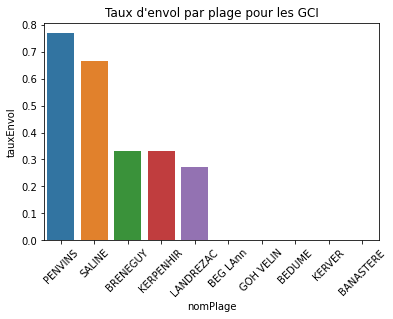

In [28]:
# Taux d'envol par plage pour les GCI
new_df = pd.read_sql("""
                        SELECT nomPlage,sum(nbEnvol)/sum(nombre) tauxEnvol 
                        FROM Obs_GCI 
                            JOIN Nid_GCI on idNid = leNid
                        WHERE nature = "oeuf"
                        GROUP BY nomPlage
                        ORDER BY tauxEnvol DESC
                    """
                 , con=db_connection)

sns.barplot(x='nomPlage', y='tauxEnvol', data=new_df)
plt.xticks(rotation = 45)
plt.title("Taux d'envol par plage pour les GCI")
print()

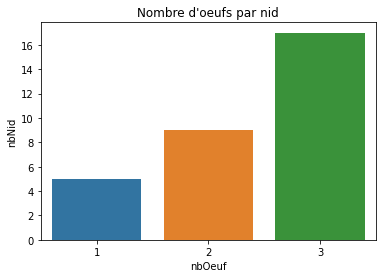

In [29]:
# Nombre d'oeufs par nid
df = pd.read_sql("""
                        SELECT nombre nbOeuf, COUNT(idNid) nbNid
                        FROM Nid_GCI
                            LEFT JOIN Obs_GCI ON idNid = leNid
                        WHERE nature = "Oeuf"
                        GROUP BY nombre
                    """
                 , con=db_connection)



sns.barplot(x='nbOeuf', y='nbNid', data=df)
plt.title("Nombre d'oeufs par nid")
print()





,nbPoussins,nbNid
0,2,13
1,3,8
2,1,4


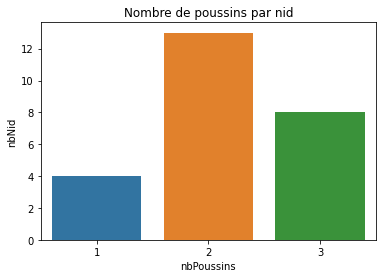

In [130]:
# Nombre de poussins par nid
df = pd.read_sql("""
                        SELECT nombre nbPoussins, COUNT(idNid) nbNid
                        FROM Nid_GCI
                            LEFT JOIN Obs_GCI ON idNid = leNid
                        WHERE nature = "Poussin"
                        GROUP BY nombre
                    """
                 , con=db_connection)



sns.barplot(x='nbPoussins', y='nbNid', data=df)
plt.title("Nombre de poussins par nid")
print()

In [317]:

dfNbObs = pd.read_sql("""
                        SELECT OblL, commune, count(indice)
                        FROM Obs_Loutre
                        WHERE indice = 'positif'
                        GROUP BY commune
                        ORDER BY commune;
                    """
                 , con=db_connection)

dfAllCom = pd.read_sql("""
                        SELECT OblL, commune
                        FROM Obs_Loutre
                        GROUP BY commune
                        ORDER BY commune;
                    """
                       , con=db_connection)

dfNbObs = dfNbObs.dropna()
dfAllCom = dfAllCom.dropna()
'''
dfNbObs = dfNbObs.dropna()
dict_obsPos = {"positif":1, "negatif":0}

series_obsPos = pd.Series(dict_obsPos)
df_obsPos = pd.DataFrame(series_obsPos, columns=["nbObservationsPositive"])

df_obsPos_final = pd.merge(
    dfNbObs[["indice"]],
    df_obsPos,
    left_on="indice",
    right_index=True,
    how="inner")

numCol = dfNbObs.columns.get_loc("indice")
dfNbObs.insert(numCol+1, "nbObservationsPositive", df_obsPos_final["nbObservationsPositive"])

sns.barplot(x='commune', y='nbObservationsPositive', data=dfNbObs, )
plt.xticks(rotation = 90)
plt.title("Nombre de loutre observée par commune")
plt.show()
'''

'\ndfNbObs = dfNbObs.dropna()\ndict_obsPos = {"positif":1, "negatif":0}\n\nseries_obsPos = pd.Series(dict_obsPos)\ndf_obsPos = pd.DataFrame(series_obsPos, columns=["nbObservationsPositive"])\n\ndf_obsPos_final = pd.merge(\n    dfNbObs[["indice"]],\n    df_obsPos,\n    left_on="indice",\n    right_index=True,\n    how="inner")\n\nnumCol = dfNbObs.columns.get_loc("indice")\ndfNbObs.insert(numCol+1, "nbObservationsPositive", df_obsPos_final["nbObservationsPositive"])\n\nsns.barplot(x=\'commune\', y=\'nbObservationsPositive\', data=dfNbObs, )\nplt.xticks(rotation = 90)\nplt.title("Nombre de loutre observée par commune")\nplt.show()\n'

In [307]:
print(type(dfNbObs))

<class 'pandas.core.frame.DataFrame'>


In [263]:
def countNbObs(x):
    s = 0
    for i in x:
        if i == 1:
            s = s + 1
    return s

In [301]:
test = df.groupby(['commune'])["nbObservationsPositive"].apply(countNbObs)
tmp = df.groupby('commune')
df["nbObsPos"] = tmp["nbObservationsPositive"].transform(lambda x: countNbObs(x))

df.groupby(["commune"]).head()

#df = df.drop(columns='nbObsPos')
df.groupby(["commune"]).head()
df

KeyError: 'Column not found: nbObservationsPositive'

In [331]:
dfAllCom = pd.read_sql("""
                        SELECT ObsL, commune
                        FROM Obs_Loutre
                        GROUP BY commune
                        ORDER BY commune;
                    """
                       , con=db_connection)
dfNbObs = pd.read_sql("""
                        SELECT ObsL, commune, count(indice)
                        FROM Obs_Loutre
                        WHERE indice = 'positif'
                        GROUP BY commune
                        ORDER BY commune;
                    """
                      , con=db_connection)

dfAllCom.dropna()
dfNbObs.dropna()

dfNbObs



df_obsPos_final = dfAllCom.merge(dfNbObs, on='ObsL', how='left')


DatabaseError: Execution failed on sql '
                        SELECT ObsL, commune
                        FROM Obs_Loutre
                        GROUP BY commune
                        ORDER BY commune;
                    ': 1055 (42000): Expression #1 of SELECT list is not in GROUP BY clause and contains nonaggregated column 'PNR.Obs_Loutre.ObsL' which is not functionally dependent on columns in GROUP BY clause; this is incompatible with sql_mode=only_full_group_by